In [1]:
import pandas as pd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV,ParameterGrid
import warnings; warnings.simplefilter('ignore')
from sklearn.ensemble import VotingClassifier
import pickle
%matplotlib inline
sns.set()
sns.set_style('whitegrid', {'axes.grid' : False})

C:\Users\virrginie.broly\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\virrginie.broly\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
# Import data and create one dataframe
df_1 = pd.read_csv('sql_export_retention_v2.csv')
df_2 = pd.read_csv('sql_export_connections_v2.csv')
df_3 = pd.read_csv('export_payments_v2.csv')
df_4 = pd.read_csv ('sql_export_chat_requests_received_v2.csv')
df_5 = pd.read_csv('sql_export_chat_requests_sent_v2.csv')
df_6 = pd.read_csv('sql_export_crons_spent_v2.csv')
df_7 = pd.read_csv('sql_export_rating_given_v2.csv')
df_8 = pd.read_csv('sql_export_rating_received_v2.csv')
banned = pd.read_csv('banned_since_jan19_2020_03_03.csv')
df = reduce(lambda  left,right: pd.merge(left,right,on=['user_id'],how='outer'), [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8])

# Cleaning

In [5]:
## Missing values
df.isna().sum()
### Dropping 1 row without user_id
df.drop(df[df.user_id.isna()].index,axis=0, inplace=True)
### user_gender : drop nan
missing_gender = df[df.user_gender.isna()]
df.drop(df[df.user_gender.isna()].index,axis=0, inplace=True)
### user_country : 1 missing value : check in db seems to be in Africa/Windhoek time zone so filled with NA (Namibia)
df.user_country.fillna('NA', inplace = True)
### max_match_num : this col is nan when the user has not made anny connection during the 5 first days => fill with 0
df.max_match_num.fillna(0, inplace = True)
### max_connection_num: this col is nan when the user has not made anny connection during the 5 first days => fill with 0
df.max_connection_num.fillna(0, inplace = True)
### payments : the 4 payment columns are nan when the user has not made any purchase during the 5 first days => fill with 0
df.crowns_usd_5d.fillna(0, inplace = True)
df.sub_usd_5d.fillna(0, inplace = True)
df.sub_re_usd_5d.fillna(0, inplace = True)
df.discount_usd_5d.fillna(0, inplace = True)
### payments : replace subscription renewal by subscription 
df['sub_usd_5d'] = df.eval('sub_usd_5d + sub_re_usd_5d')
df.drop('sub_re_usd_5d', axis=1, inplace=True)
### chat requests : same as previous=> fill with 0
df.chat_request_received_5d.fillna(0, inplace = True)
df.chat_request_sent_5d.fillna(0, inplace = True)
### crowns spent : same as previous
df.crowns_spent_chat_5d.fillna(0, inplace = True)
df.crowns_spent_message_5d.fillna(0, inplace = True)
df.crowns_spent_match_now_5d.fillna(0, inplace = True)
df.crowns_spent_discover_5d.fillna(0, inplace = True)
df.crowns_spent_pick_5d.fillna(0, inplace = True)
df.crowns_spent_instant_match_now_5d.fillna(0, inplace = True)
df.crowns_spent_more_pick_5d.fillna(0, inplace = True)
df.crowns_spent_average_rating_5d .fillna(0, inplace = True)
df.crowns_spent_another_5d.fillna(0, inplace = True)
df.crowns_spent_curated_user_5d.fillna(0, inplace = True)
df.crowns_spent_curated_user_attractive_5d.fillna(0, inplace = True)
df.crowns_spent_curated_user_close_5d.fillna(0, inplace = True)
df.crowns_spent_curated_user_serious_5d.fillna(0, inplace = True)
df.crowns_spent_curated_user_new_5d.fillna(0, inplace = True)
df.crowns_spent_curated_user_alone_5d.fillna(0, inplace = True)
df.crowns_spent_more_rating_5d .fillna(0, inplace = True)
df.crowns_spent_rematch_5d .fillna(0, inplace = True)
df.crowns_spent_reset_rating_5d.fillna(0, inplace = True)
df.crowns_spent_pick_from_ratings_5d.fillna(0, inplace = True)
df.crowns_spent_stalk_5d.fillna(0, inplace = True)
### ratings : same as previous
df.rating_given.fillna(0, inplace = True)
df.avg_rating_given .fillna(0, inplace = True)
df.rating_received.fillna(0, inplace = True)
df.avg_rating_received.fillna(0, inplace = True)

# Create a total login column
df['login_5d']= df.eval('1+d1+d2+d3+d4')
# Create a total spent column and a has_spent columns
df['total_spent']=df.eval('crowns_usd_5d+sub_usd_5d+discount_usd_5d')
df['has_spent']=df.total_spent.apply(lambda x: 1 if x>0 else 0)
# Create a total crowns_spent column
df['total_crowns_spent'] = df.eval ('crowns_spent_chat_5d+crowns_spent_message_5d+crowns_spent_match_now_5d+crowns_spent_discover_5d+crowns_spent_pick_5d+crowns_spent_instant_match_now_5d+crowns_spent_more_pick_5d+crowns_spent_average_rating_5d+crowns_spent_another_5d+crowns_spent_curated_user_5d+crowns_spent_curated_user_attractive_5d+crowns_spent_curated_user_close_5d+ crowns_spent_curated_user_serious_5d+ crowns_spent_curated_user_new_5d+ crowns_spent_curated_user_alone_5d+ crowns_spent_more_rating_5d+ crowns_spent_rematch_5d+crowns_spent_reset_rating_5d+ crowns_spent_pick_from_ratings_5d+ crowns_spent_stalk_5d')

# Countries
def countries(x):
    top_lst = ['FR','IT', 'DE', 'BR', 'BE', 'CH', 'US', 'GB', 'AT', 'NL', 'CA']
    eur_lst = ['AL', 'AD', 'AM', 'BY', 'BA', 'BG', 'CY','CZ', 'DK', 'EE', 'ES', 'FO', 'FI',
               'GI','GR', 'HU', 'HR', 'IE', 'IS', 'LI', 'LT', 'LU', 'LV', 'MC', 'MK', 'MT', 'NO', 'PL', 'PT', 'RO', 'RU', 'SE', 'SI', 'SK', 'SM', 'TR', 'UA', 'VA']
    asia_lst = ['CN', 'YE', 'IN','AU','NZ', 'HK', 'JP', 'AF', 'AZ', 'BH', 'BD', 'BT', 'BN', 'KH', 'GE', 'ID', 'IR', 'IQ', 'IL', 'JO', 'KZ', 'KW', 'KG', 'LA', 'LB', 'MO', 'MY', 'MV', 'MN', 'MM', 'NP', 'KP', 'OM', 'PK', 'PH', 'QA', 'SA', 'SG', 'KR', 'LK', 'SY', 'TW', 'TJ', 'TH', 'TM', 'AE', 'UZ', 'VN']
    africa_lst = ['MA', 'CI','RE', 'DZ', 'NG', 'EG', 'TN','AE']
    southam_lst = ['MX','AR', 'CO','CL','PE', 'BO', 'BR', 'VG', 'CR', 'CU', 'CW', 'DM', 'DO', 'EC', 'SV', 'FK', 'GL', 'GP', 'GT', 'GY', 'HT', 'JM', 'NI', 'PA', 'PY', 'PR', 'BL', 'KN', 'LC', 'MF', 'PM', 'VC', 'SR', 'TT', 'UY', 'VE']
    if x in top_lst :
        return x
    elif x in eur_lst:
        return 'other EU'
    elif x in asia_lst:
        return 'other Asia'
    elif x in africa_lst:
        return 'other Africa'
    elif x in southam_lst:
        return 'other South America'
    else :
        return 'other'
df['country']= df.user_country.apply(lambda x: countries(x))
df.drop('user_country', axis=1, inplace=True)

# Acquisition
def paid(x):
    if x in ['Organic', 'Google Organic Search']:
        return 0
    else :
        return 1
df['paid_user'] = df.network.apply(lambda x: paid(x))
df.drop('network', axis=1, inplace=True)

# Drop the "curated" crowns spending types because new feature
col_drop = ['crowns_spent_curated_user_5d','crowns_spent_curated_user_attractive_5d','crowns_spent_curated_user_close_5d','crowns_spent_curated_user_serious_5d', 'crowns_spent_curated_user_new_5d', 'crowns_spent_curated_user_alone_5d']
df.drop(col_drop, axis=1, inplace=True)

# Drop banned accounts
banned['status']= 'banned'
banned.rename ( columns = {'Id' : 'user_id'}, inplace=True)
df = df.merge(banned, on='user_id', how='left')
df.drop(df[df['status']=='banned'].index, inplace = True)
df.drop('status', axis=1, inplace= True)

# Data Processing

In [6]:
df1=df.copy()
# Remove unecessary columns
col_remove= ['install_date', 'user_id', 'max_match_num','total_spent', 'has_spent', 'total_crowns_spent']
df1.drop(col_remove, axis=1, inplace=True)
# Age create bins
df1['age']= pd.cut(df1['user_age'], [18, 28, 38, 48,150], labels = [ '18_28','29-38', '38-48', 'more than 48'])
df1.drop('user_age', axis=1, inplace=True)
# Create dummies
col_dummies=['user_platform', 'country', 'age']
df1 = pd.get_dummies(data=df1, columns=col_dummies, drop_first=True)

# Transform crowns_usd_5d, sub_usd_5d, discount_usd_5d into dummies
df1['crowns_usd_5d']= df1.crowns_usd_5d.apply(lambda x: 1 if x>0 else 0)
df1['sub_usd_5d']= df1.sub_usd_5d.apply(lambda x: 1 if x>0 else 0)
df1['discount_usd_5d']= df1.discount_usd_5d.apply(lambda x: 1 if x>0 else 0)

# Transform connection into dummies
df1['connection']= df1.max_connection_num.apply(lambda x: 1 if x>0 else 0)
df1.drop('max_connection_num', axis=1, inplace=True)

# drop columns with low values and d1, d2, d3, d4 , login_w& that are providing the same info as login_5d
col_drop2 = ['d1', 'd2','d3', 'd4','crowns_spent_average_rating_5d','crowns_spent_another_5d','crowns_spent_more_rating_5d','crowns_spent_rematch_5d','crowns_spent_reset_rating_5d','crowns_spent_pick_from_ratings_5d','crowns_spent_stalk_5d', 'paid_user']
df1.drop(col_drop2, axis=1, inplace=True)

# Transformcrowns usage columns into dummies
crown_lst =['connection','crowns_spent_chat_5d','crowns_spent_message_5d','crowns_spent_match_now_5d','crowns_spent_discover_5d', 'crowns_spent_pick_5d','crowns_spent_instant_match_now_5d', 'crowns_spent_more_pick_5d']
for i in crown_lst:
    df1[i]= df1[i].apply(lambda x: 1 if x>0 else 0)


# split into 2 df : Men / Women
df1_m = df1[df1.user_gender=='m']
df1_w = df1[df1.user_gender=='w']

# WORKING ON MEN
df1_m.drop(['user_gender'], axis=1, inplace=True)

# Winsorize
winsorize(df1_m.rating_given,limits=[0,0.05],inplace=True)
winsorize(df1_m.rating_received,limits=[0,0.05],inplace=True)
winsorize(df1_m.chat_request_received_5d,limits=[0,0.05],inplace=True)
winsorize(df1_m.chat_request_sent_5d,limits=[0,0.05],inplace=True)


# Scaling : creating of a df with scaled columns
scaler = StandardScaler()
df1_m[['login_5d','chat_request_received_5d','chat_request_sent_5d','avg_rating_given','avg_rating_received', 'rating_given', 'rating_received']] = scaler.fit_transform(df1_m[['login_5d','chat_request_received_5d','chat_request_sent_5d','avg_rating_given','avg_rating_received', 'rating_given', 'rating_received']])

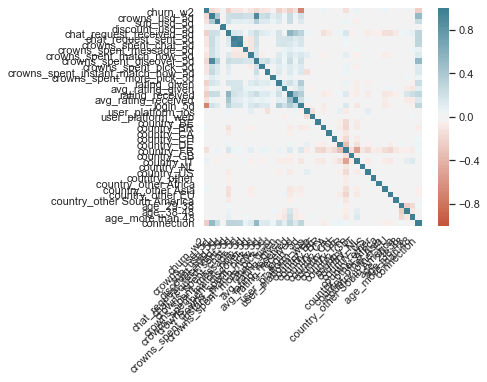

In [7]:
# Correlation matrix
# Matrix
correlation = df1_m.corr()

# Plotting
ax = sns.heatmap(
    correlation, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels=True, 
    yticklabels=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Model

In [9]:
# Using the statsmodel logistic regression to detect the most important variables
X=df1_m.drop('churn_w2', axis=1).copy()
X.reset_index(inplace=True, drop = True)
y = df1_m['churn_w2']
y.reset_index(inplace=True, drop = True)
model1=sm.Logit(y,X)
result1=model1.fit()
print(result1.summary2())

         Current function value: 0.413440
         Iterations: 35
                                       Results: Logit
Model:                       Logit                     Pseudo R-squared:          0.402     
Dependent Variable:          churn_w2                  AIC:                       62179.6538
Date:                        2020-03-16 15:15          BIC:                       62530.2667
No. Observations:            75106                     Log-Likelihood:            -31052.   
Df Model:                    37                        LL-Null:                   -51936.   
Df Residuals:                75068                     LLR p-value:               0.0000    
Converged:                   0.0000                    Scale:                     1.0000    
No. Iterations:              35.0000                                                        
--------------------------------------------------------------------------------------------
                                   Coef.   

In [10]:
# Removing the columns for which p_value is higher than 0.05
cols =['discount_usd_5d', 'chat_request_received_5d', 'crowns_spent_chat_5d', 'crowns_spent_discover_5d',\
       'rating_received', 'country_other', 'country_other Africa'] 
X.drop(cols, axis=1, inplace=True)

In [13]:
#splitting train and test data
X1_train, X1_test, y1_train, y1_test = train_test_split(X,y,test_size=0.3, random_state=42, stratify=y)

# Function attribute
#Algorithm     - Algorithm used 
#training_x    - predictor variables dataframe(training)
#testing_x     - predictor variables dataframe(testing)
#training_y    - target variable(training)
#training_y    - target variable(testing)
#cf - ["coefficients","features"](cooefficients for logistic regression,features for tree based models)

def churn_prediction(algorithm,training_x,testing_x,training_y,testing_y,cols,cf):
    # model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
    column_df= pd.DataFrame(cols)
    coef_sumry= (pd.merge(coefficients,column_df,left_index= True,right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy Score : ",accuracy_score(testing_y,predictions))
    print ("Recall Score : ",recall_score(testing_y,predictions))
    print("Precision Score : ",precision_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    plt.figure()
    matrix =sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    matrix.set_xticklabels(['No churn', 'Churn'])
    matrix.set_yticklabels(['No churn', 'Churn'])
    matrix.set_title('Confusion matrix')

    #plot roc curve
    fpr,tpr,thresholds=roc_curve(testing_y, probabilities[:,1])
    plt.figure()
    plt.plot(fpr,tpr,label=f'Roc (area={model_roc_auc})')
    plt.plot([0,1],[0,1])
    plt.legend()
    plt.title('Model performance')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()
    #plot coeffs
    plt.figure()
    coef_plot= sns.barplot(x = coef_sumry["features"],y = coef_sumry["coefficients"])
    coef_plot.set_title=('Features importance')
    coef_plot.set_xticklabels(coef_plot.get_xticklabels(), rotation = 90)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.80      0.85      0.82     10621
         1.0       0.85      0.81      0.83     11911

    accuracy                           0.83     22532
   macro avg       0.83      0.83      0.83     22532
weighted avg       0.83      0.83      0.83     22532

Accuracy Score :  0.8260695899165631
Recall Score :  0.808160523885484
Precision Score :  0.8548845470692717
Area under curve :  0.827157185019665 



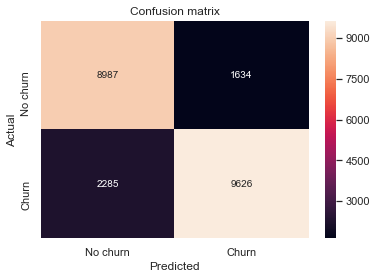

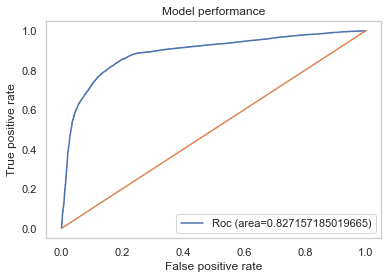

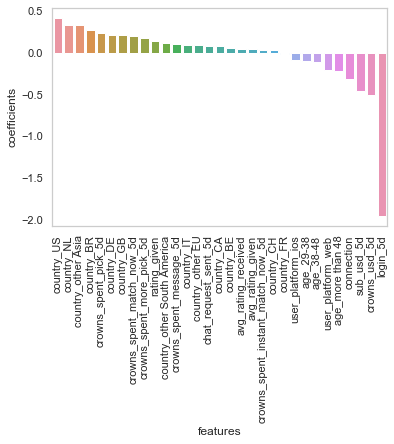

In [14]:
# Model 1 : logistic regression default
logit = LogisticRegression()
churn_prediction(logit,X1_train,X1_test,y1_train, y1_test,X.columns,'coefficients')

In [15]:
## Feature Engineering : RFE
logit2= LogisticRegression(max_iter=100)
selector = RFE(logit2,15)
selector = selector.fit(X,y)
selector.ranking_
selector.support_

idc_rfe = pd.DataFrame({'rfe_support' : selector.support_, 'columns' : X.columns, 'ranking' :selector.ranking_ })
selected_cols = idc_rfe['columns'][idc_rfe['rfe_support']==True].tolist()
X1 = X[selected_cols]

## Feature engineering : PCA
pca = PCA(0.9)
pca.fit(X)
print(pca.explained_variance_ratio_)
X1_PCA =pca.transform(X1_train)

[0.25438015 0.13631948 0.13116241 0.1213392  0.08836749 0.04371468
 0.03107814 0.03038736 0.02144856 0.02033796 0.01703905 0.01515044]


In [16]:
X1.columns

Index(['crowns_usd_5d', 'sub_usd_5d', 'crowns_spent_pick_5d', 'rating_given',
       'login_5d', 'user_platform_web', 'country_BR', 'country_DE',
       'country_GB', 'country_NL', 'country_US', 'country_other Asia',
       'country_other South America', 'age_more than 48', 'connection'],
      dtype='object')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.80      0.85      0.82     10621
         1.0       0.85      0.81      0.83     11911

    accuracy                           0.83     22532
   macro avg       0.83      0.83      0.83     22532
weighted avg       0.83      0.83      0.83     22532

Accuracy Score :  0.8256257766731759
Recall Score :  0.8071530518008564
Precision Score :  0.854881735728259
Area under curve :  0.8267476020702803 



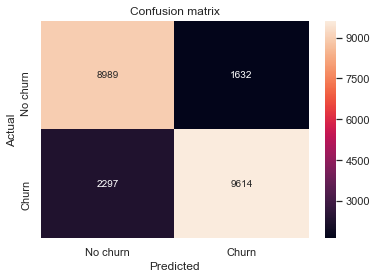

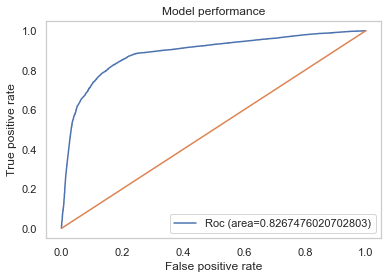

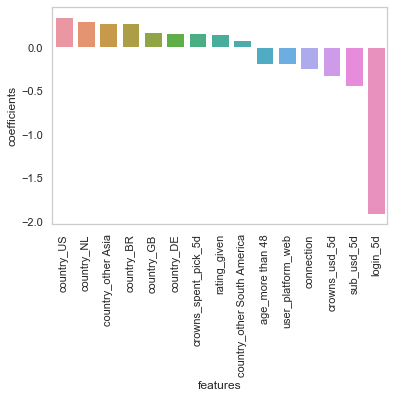

In [17]:
# Model 2 : logitstic regression with RFE
X2_train, X2_test, y2_train, y2_test = train_test_split(X1,y,test_size=0.3, random_state=42, stratify=y)
churn_prediction(logit,X2_train,X2_test,y2_train, y2_test,X1.columns,'coefficients')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.80      0.85      0.82     10621
         1.0       0.85      0.81      0.83     11911

    accuracy                           0.83     22532
   macro avg       0.83      0.83      0.83     22532
weighted avg       0.83      0.83      0.83     22532

Accuracy Score :  0.825936445943547
Recall Score :  0.8077407438502224
Precision Score :  0.854972007464676
Area under curve :  0.8270414480949634 



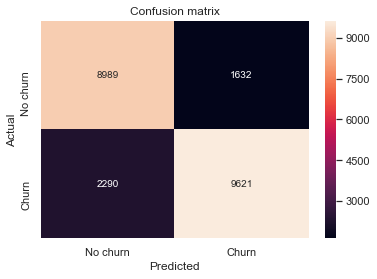

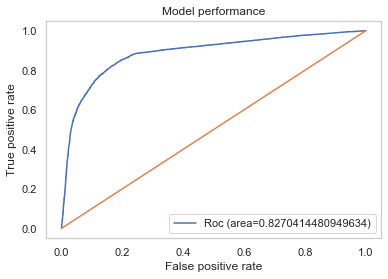

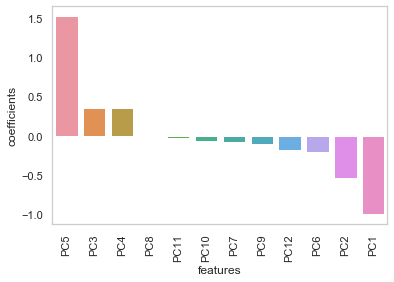

In [18]:
# Model3: logitstic regression with PCA
pca_col = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12']
churn_prediction(logit,X1_PCA,pca.transform(X1_test),y1_train, y1_test,pca_col,'coefficients')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.73      0.72      0.73     10621
         1.0       0.76      0.76      0.76     11911

    accuracy                           0.74     22532
   macro avg       0.74      0.74      0.74     22532
weighted avg       0.74      0.74      0.74     22532

Accuracy Score :  0.7448961477010474
Recall Score :  0.7628242800772396
Precision Score :  0.7565992172537264
Area under curve :  0.7438073947227362 



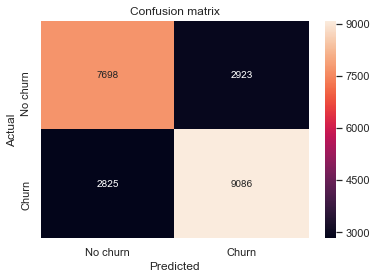

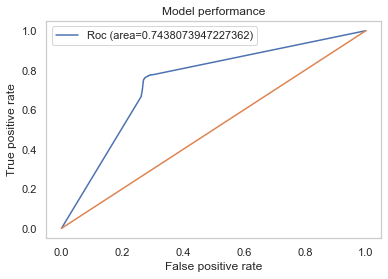

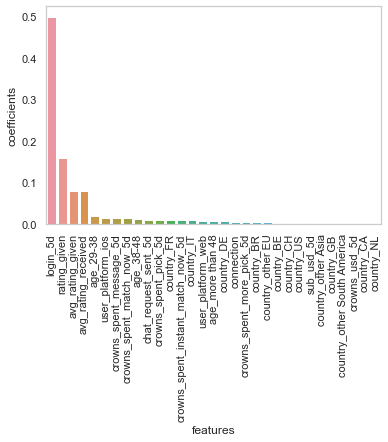

In [19]:
# Model 4 : Decision tree without Feature Engineering
decision = DecisionTreeClassifier()
churn_prediction(decision,X1_train,X1_test,y1_train, y1_test,X.columns,'features')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.76      0.81      0.79     10621
         1.0       0.82      0.78      0.80     11911

    accuracy                           0.79     22532
   macro avg       0.79      0.79      0.79     22532
weighted avg       0.79      0.79      0.79     22532

Accuracy Score :  0.7914521569323628
Recall Score :  0.776173285198556
Precision Score :  0.8197375421173967
Area under curve :  0.792380023636845 



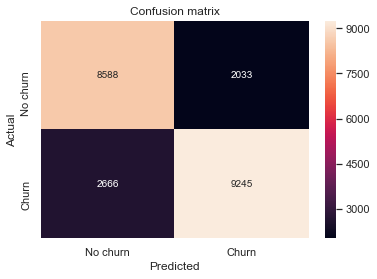

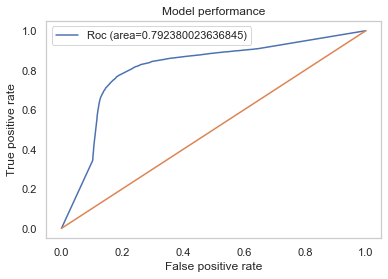

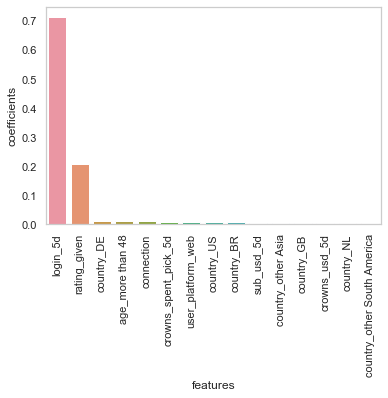

In [20]:
# Model 5 : Decision tree with RFE
churn_prediction(decision,X2_train,X2_test,y2_train, y2_test,X1.columns,'features')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.73      0.73      0.73     10621
         1.0       0.76      0.76      0.76     11911

    accuracy                           0.75     22532
   macro avg       0.74      0.74      0.74     22532
weighted avg       0.75      0.75      0.75     22532

Accuracy Score :  0.7452068169714184
Recall Score :  0.7602216438586181
Precision Score :  0.7583752093802345
Area under curve :  0.7442949853790783 



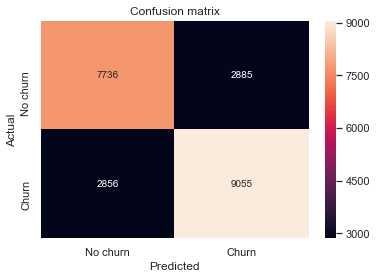

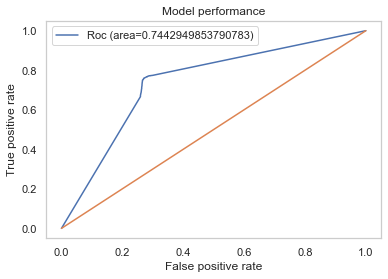

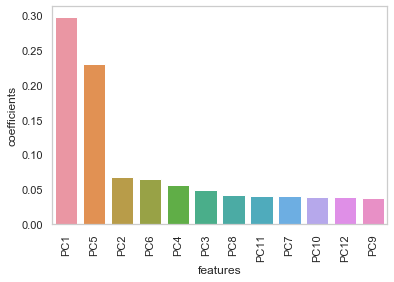

In [21]:
# Model 6: Decision tree with PCA
churn_prediction(decision,X1_PCA,pca.transform(X1_test),y1_train, y1_test,pca_col,'features')

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.79      0.82      0.81     10621
         1.0       0.84      0.81      0.82     11911

    accuracy                           0.81     22532
   macro avg       0.81      0.81      0.81     22532
weighted avg       0.82      0.81      0.81     22532

Accuracy Score :  0.8140866323451091
Recall Score :  0.8051381076316011
Precision Score :  0.83696

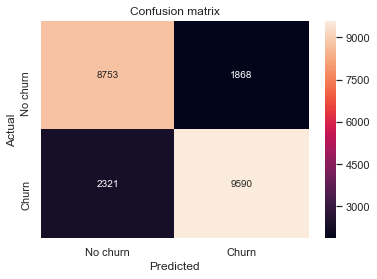

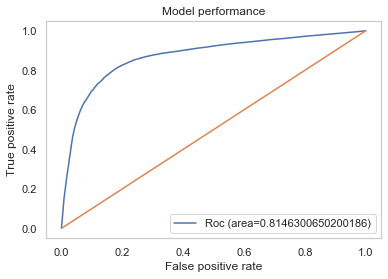

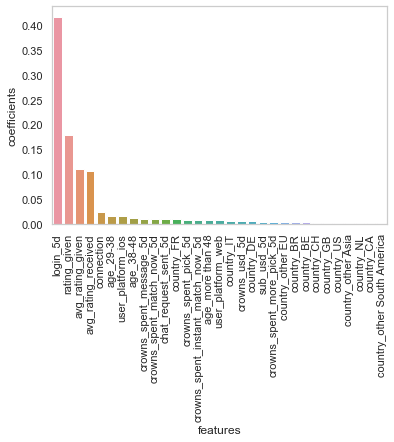

In [22]:
# Model 7 : Random Forest without Feature Engineering
forest = RandomForestClassifier()
churn_prediction(forest,X1_train,X1_test,y1_train, y1_test,X.columns,'features')

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.77      0.79      0.78     10621
         1.0       0.81      0.79      0.80     11911

    accuracy                           0.79     22532
   macro avg       0.79      0.79      0.79     22532
weighted avg       0.79      0.79      0.79     22532

Accuracy Score :  0.7939375110953311
Recall Score :  0.7933003106372261
Precision Score :  0.81246

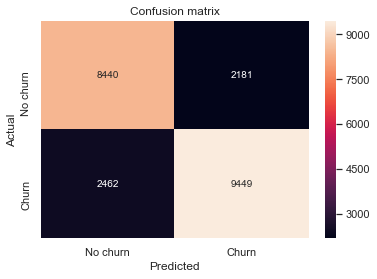

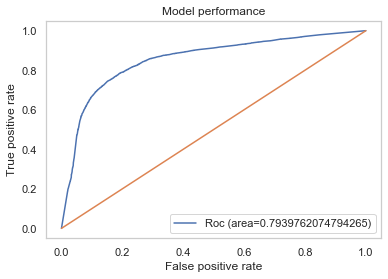

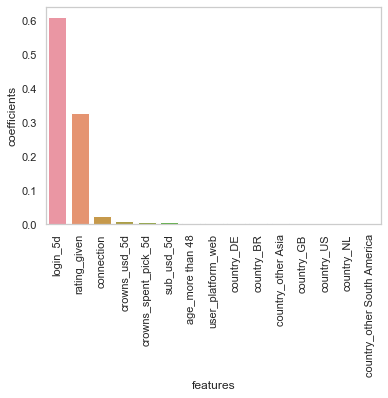

In [23]:
# Model 8: Random Forest with RFE
churn_prediction(forest,X2_train,X2_test,y2_train, y2_test,X1.columns,'features')

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.79      0.83      0.81     10621
         1.0       0.84      0.80      0.82     11911

    accuracy                           0.81     22532
   macro avg       0.81      0.81      0.81     22532
weighted avg       0.81      0.81      0.81     22532

Accuracy Score :  0.811601278182141
Recall Score :  0.7986734950885735
Precision Score :  0.837411

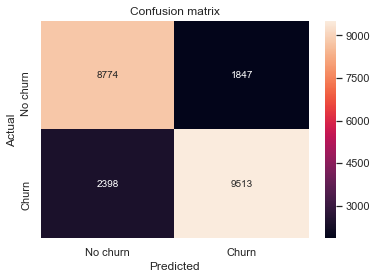

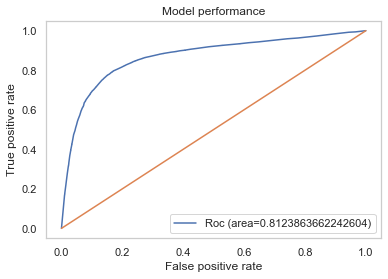

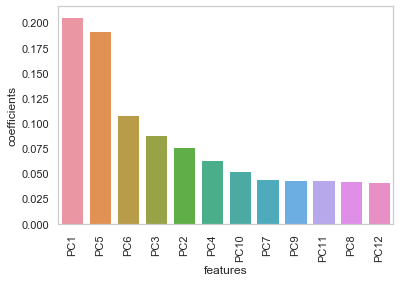

In [24]:
# Model 9: Random Forest with PCA
churn_prediction(forest,X1_PCA,pca.transform(X1_test),y1_train, y1_test,pca_col,'features')

In [25]:
# KNN : creation of a fucntion to run the model and display the results
def churn_prediction2(algorithm,training_x,testing_x,training_y,testing_y):
    # model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
        
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    print ("Recall Score : ",recall_score(testing_y,predictions))
    print("Precision Score : ",precision_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    plt.figure()
    matrix =sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    matrix.set_xticklabels(['No churn', 'Churn'])
    matrix.set_yticklabels(['No churn', 'Churn'])
    matrix.set_title('Confusion matrix')

    #plot roc curve
    fpr,tpr,thresholds=roc_curve(testing_y, probabilities[:,1])
    plt.figure()
    plt.plot(fpr,tpr,label=f'Roc (area={model_roc_auc})')
    plt.plot([0,1],[0,1])
    plt.legend()
    plt.title('Model performance')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()

In [26]:
# KNN : creation of a function that displays the best number of neighbors for highest recall score
### Find the best number of neighbors
def best_neigh(training_x,testing_x,training_y,testing_y) :
    precision = []
    for k in range(3,15,2):
        model = KNeighborsClassifier(k)
        precision.append(recall_score(testing_y, model.fit(training_x, training_y).predict(testing_x)))
    plt.plot(range(3,15,2), precision, 'o-')
    plt.title('Recall according to number of neighbours')
    plt.xlabel('Number of neighbours')
    plt.ylabel('Recall')
    plt.show()

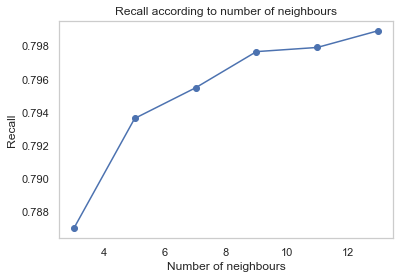

In [27]:
# KNN without feature engineering
best_neigh(X1_train,X1_test,y1_train, y1_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.79      0.84      0.81     10621
         1.0       0.85      0.80      0.82     11911

    accuracy                           0.82     22532
   macro avg       0.82      0.82      0.82     22532
weighted avg       0.82      0.82      0.82     22532

Accuracy   Score :  0.8193680099414167
Recall Score :  0.7989253631097305
Precision Score :  0.8503261549459387
Area under curve :  0.8206094662267417 



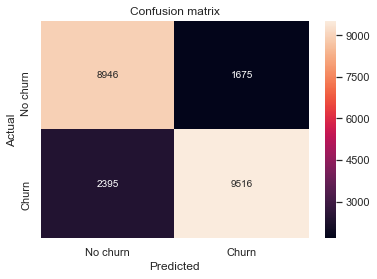

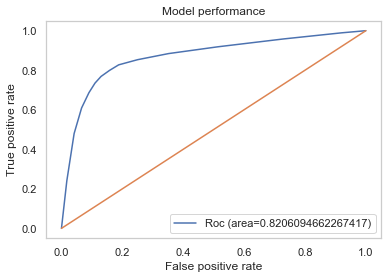

In [28]:
# Model 10 : KNN without feature engineering
knn= KNeighborsClassifier(13)
churn_prediction2(knn,X1_train,X1_test,y1_train, y1_test) 

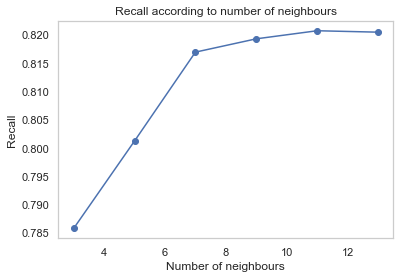

In [29]:
# KNN with RFE
best_neigh(X2_train,X2_test,y2_train,y2_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.80      0.82      0.81     10621
         1.0       0.84      0.82      0.83     11911

    accuracy                           0.82     22532
   macro avg       0.82      0.82      0.82     22532
weighted avg       0.82      0.82      0.82     22532

Accuracy   Score :  0.8215870761583526
Recall Score :  0.8207539249433297
Precision Score :  0.8383500557413601
Area under curve :  0.8216376723859855 



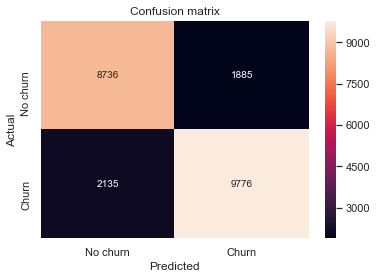

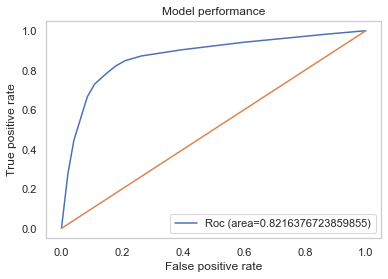

In [30]:
# Model 11: KNN with RFE
knn2= KNeighborsClassifier(11)
churn_prediction2(knn2,X2_train,X2_test,y2_train,y2_test) 

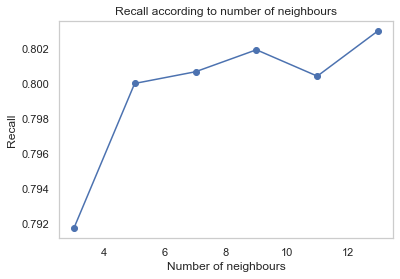

In [31]:
# KNN with PCA
best_neigh(X1_PCA,pca.transform(X1_test),y1_train,y1_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.79      0.84      0.82     10621
         1.0       0.85      0.80      0.83     11911

    accuracy                           0.82     22532
   macro avg       0.82      0.82      0.82     22532
weighted avg       0.82      0.82      0.82     22532

Accuracy   Score :  0.8220752707260784
Recall Score :  0.8030392074552934
Precision Score :  0.851888136800855
Area under curve :  0.8232313069570978 



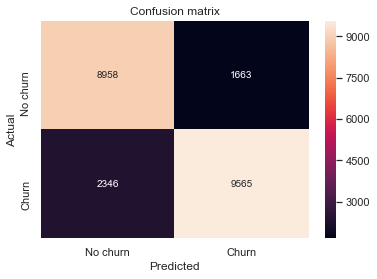

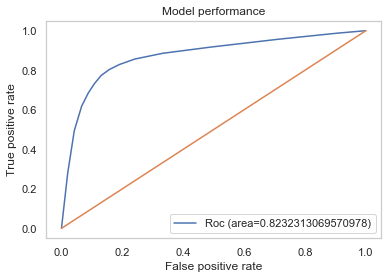

In [32]:
# Model 12 : KNN with PCA
knn3= KNeighborsClassifier(13)
churn_prediction2(knn3,X1_PCA,pca.transform(X1_test),y1_train,y1_test)

GaussianNB(priors=None, var_smoothing=1e-09)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.76      0.71      0.74     10621
         1.0       0.76      0.80      0.78     11911

    accuracy                           0.76     22532
   macro avg       0.76      0.76      0.76     22532
weighted avg       0.76      0.76      0.76     22532

Accuracy   Score :  0.7591869341381147
Recall Score :  0.799345143144992
Precision Score :  0.7582225053754877
Area under curve :  0.756748176506118 



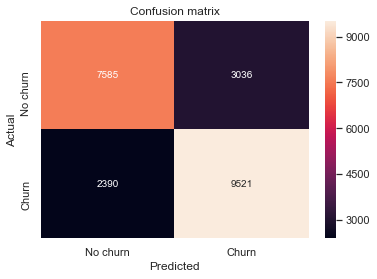

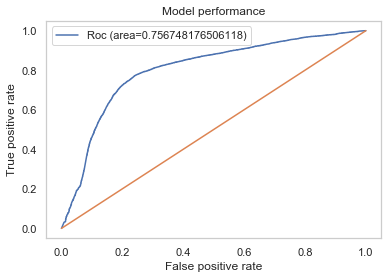

In [33]:
# Model 12 Naive Bayes without Feature Engineering
bayes = GaussianNB()
churn_prediction2(bayes,X1_train,X1_test,y1_train, y1_test) 

GaussianNB(priors=None, var_smoothing=1e-09)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.79      0.74      0.77     10621
         1.0       0.78      0.82      0.80     11911

    accuracy                           0.78     22532
   macro avg       0.78      0.78      0.78     22532
weighted avg       0.78      0.78      0.78     22532

Accuracy   Score :  0.7846174329842003
Recall Score :  0.8203341449080682
Precision Score :  0.7826818327459147
Area under curve :  0.7824484018957062 



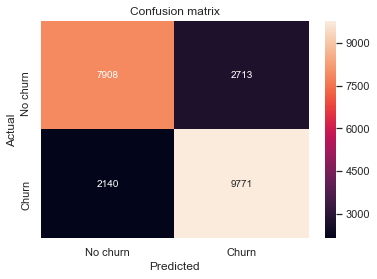

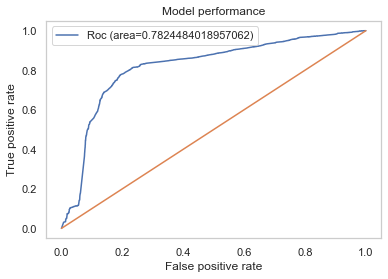

In [34]:
# Model 13 Naive Bayes with RFE
churn_prediction2(bayes,X2_train,X2_test,y2_train,y2_test)

GaussianNB(priors=None, var_smoothing=1e-09)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.78      0.84      0.81     10621
         1.0       0.85      0.79      0.82     11911

    accuracy                           0.82     22532
   macro avg       0.82      0.82      0.82     22532
weighted avg       0.82      0.82      0.82     22532

Accuracy   Score :  0.8169714184271258
Recall Score :  0.7942238267148014
Precision Score :  0.8497260397017875
Area under curve :  0.8183528511222063 



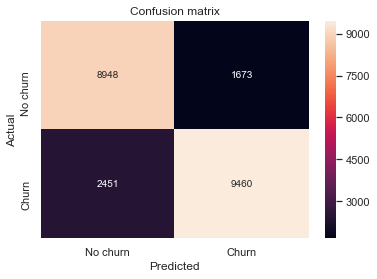

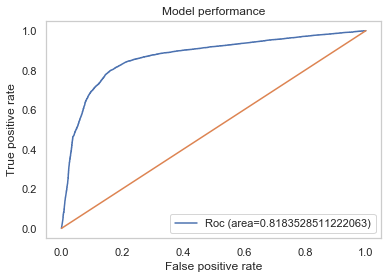

In [35]:
# Model 14 Naive Bayes with PCA
churn_prediction2(bayes,X1_PCA,pca.transform(X1_test),y1_train,y1_test)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.81      0.83      0.82     10621
         1.0       0.85      0.82      0.83     11911

    accuracy                           0.83     22532
   macro avg       0.83      0.83      0.83     22532
weighted avg       0.83      0.83      0.83     22532

Accuracy   Score :  0

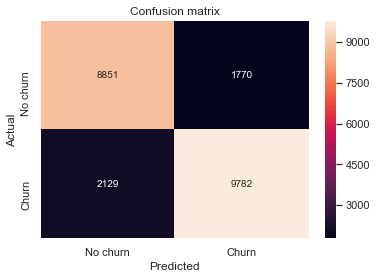

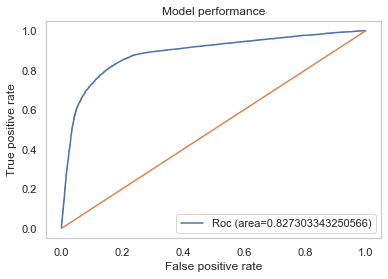

In [36]:
# Model 15 XGBoost without Feature Engineering
XGB = XGBClassifier()
churn_prediction2(XGB,X1_train,X1_test,y1_train, y1_test) 

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.81      0.83      0.82     10621
         1.0       0.84      0.82      0.83     11911

    accuracy                           0.83     22532
   macro avg       0.83      0.83      0.83     22532
weighted avg       0.83      0.83      0.83     22532

Accuracy   Score :  0

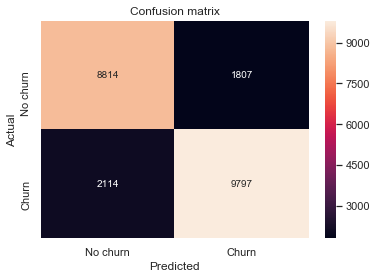

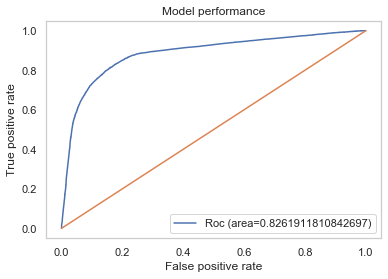

In [37]:
# Model 16 XGBoost with RFE
churn_prediction2(XGB,X2_train,X2_test,y2_train,y2_test)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.80      0.84      0.82     10621
         1.0       0.85      0.81      0.83     11911

    accuracy                           0.82     22532
   macro avg       0.82      0.82      0.82     22532
weighted avg       0.82      0.82      0.82     22532

Accuracy   Score :  0

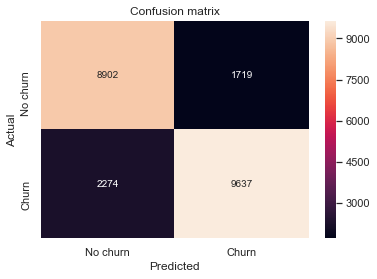

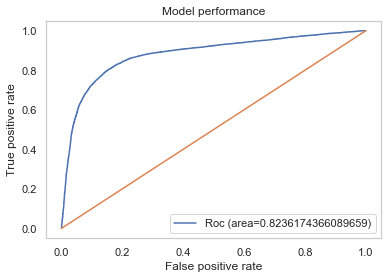

In [38]:
# Model 17 XGBoost with PCA
churn_prediction2(XGB,X1_PCA,pca.transform(X1_test),y1_train,y1_test)

Learning rate set to 0.055938
0:	learn: 0.6564950	total: 107ms	remaining: 1m 46s
1:	learn: 0.6271808	total: 125ms	remaining: 1m 2s
2:	learn: 0.5993164	total: 139ms	remaining: 46.3s
3:	learn: 0.5752051	total: 159ms	remaining: 39.6s
4:	learn: 0.5557222	total: 173ms	remaining: 34.4s
5:	learn: 0.5387552	total: 186ms	remaining: 30.9s
6:	learn: 0.5226084	total: 207ms	remaining: 29.3s
7:	learn: 0.5083891	total: 223ms	remaining: 27.7s
8:	learn: 0.4959642	total: 238ms	remaining: 26.2s
9:	learn: 0.4861621	total: 263ms	remaining: 26.1s
10:	learn: 0.4777756	total: 278ms	remaining: 25s
11:	learn: 0.4702349	total: 292ms	remaining: 24s
12:	learn: 0.4626603	total: 305ms	remaining: 23.2s
13:	learn: 0.4569819	total: 324ms	remaining: 22.8s
14:	learn: 0.4520050	total: 342ms	remaining: 22.5s
15:	learn: 0.4476630	total: 355ms	remaining: 21.8s
16:	learn: 0.4433861	total: 378ms	remaining: 21.9s
17:	learn: 0.4400545	total: 394ms	remaining: 21.5s
18:	learn: 0.4363789	total: 410ms	remaining: 21.2s
19:	learn: 0.4

168:	learn: 0.3988310	total: 2.75s	remaining: 13.5s
169:	learn: 0.3987388	total: 2.77s	remaining: 13.5s
170:	learn: 0.3986788	total: 2.79s	remaining: 13.5s
171:	learn: 0.3985933	total: 2.8s	remaining: 13.5s
172:	learn: 0.3985420	total: 2.82s	remaining: 13.5s
173:	learn: 0.3984750	total: 2.83s	remaining: 13.5s
174:	learn: 0.3984276	total: 2.85s	remaining: 13.4s
175:	learn: 0.3983876	total: 2.87s	remaining: 13.4s
176:	learn: 0.3983153	total: 2.88s	remaining: 13.4s
177:	learn: 0.3982519	total: 2.9s	remaining: 13.4s
178:	learn: 0.3982093	total: 2.92s	remaining: 13.4s
179:	learn: 0.3981734	total: 2.93s	remaining: 13.4s
180:	learn: 0.3980887	total: 2.95s	remaining: 13.3s
181:	learn: 0.3980249	total: 2.96s	remaining: 13.3s
182:	learn: 0.3979801	total: 2.98s	remaining: 13.3s
183:	learn: 0.3979306	total: 2.99s	remaining: 13.3s
184:	learn: 0.3978815	total: 3s	remaining: 13.2s
185:	learn: 0.3978572	total: 3.02s	remaining: 13.2s
186:	learn: 0.3977833	total: 3.03s	remaining: 13.2s
187:	learn: 0.397

337:	learn: 0.3901302	total: 5.34s	remaining: 10.5s
338:	learn: 0.3901162	total: 5.35s	remaining: 10.4s
339:	learn: 0.3900686	total: 5.37s	remaining: 10.4s
340:	learn: 0.3900357	total: 5.38s	remaining: 10.4s
341:	learn: 0.3899688	total: 5.39s	remaining: 10.4s
342:	learn: 0.3899588	total: 5.41s	remaining: 10.4s
343:	learn: 0.3899247	total: 5.42s	remaining: 10.3s
344:	learn: 0.3898643	total: 5.43s	remaining: 10.3s
345:	learn: 0.3898558	total: 5.45s	remaining: 10.3s
346:	learn: 0.3898114	total: 5.46s	remaining: 10.3s
347:	learn: 0.3897673	total: 5.47s	remaining: 10.2s
348:	learn: 0.3897241	total: 5.48s	remaining: 10.2s
349:	learn: 0.3896650	total: 5.5s	remaining: 10.2s
350:	learn: 0.3896239	total: 5.51s	remaining: 10.2s
351:	learn: 0.3896144	total: 5.54s	remaining: 10.2s
352:	learn: 0.3896046	total: 5.56s	remaining: 10.2s
353:	learn: 0.3895632	total: 5.59s	remaining: 10.2s
354:	learn: 0.3895249	total: 5.6s	remaining: 10.2s
355:	learn: 0.3894706	total: 5.62s	remaining: 10.2s
356:	learn: 0.

499:	learn: 0.3837589	total: 7.88s	remaining: 7.88s
500:	learn: 0.3837108	total: 7.89s	remaining: 7.86s
501:	learn: 0.3836716	total: 7.91s	remaining: 7.84s
502:	learn: 0.3836259	total: 7.92s	remaining: 7.83s
503:	learn: 0.3836008	total: 7.94s	remaining: 7.81s
504:	learn: 0.3835727	total: 7.97s	remaining: 7.81s
505:	learn: 0.3835221	total: 7.98s	remaining: 7.79s
506:	learn: 0.3834703	total: 7.99s	remaining: 7.77s
507:	learn: 0.3834578	total: 8.03s	remaining: 7.78s
508:	learn: 0.3833939	total: 8.04s	remaining: 7.76s
509:	learn: 0.3833350	total: 8.06s	remaining: 7.75s
510:	learn: 0.3832848	total: 8.08s	remaining: 7.73s
511:	learn: 0.3832158	total: 8.09s	remaining: 7.71s
512:	learn: 0.3831608	total: 8.11s	remaining: 7.7s
513:	learn: 0.3831110	total: 8.12s	remaining: 7.67s
514:	learn: 0.3830691	total: 8.13s	remaining: 7.66s
515:	learn: 0.3830686	total: 8.15s	remaining: 7.64s
516:	learn: 0.3830403	total: 8.16s	remaining: 7.62s
517:	learn: 0.3829861	total: 8.17s	remaining: 7.6s
518:	learn: 0.

662:	learn: 0.3780492	total: 10.3s	remaining: 5.22s
663:	learn: 0.3779918	total: 10.3s	remaining: 5.2s
664:	learn: 0.3779617	total: 10.3s	remaining: 5.18s
665:	learn: 0.3779053	total: 10.3s	remaining: 5.17s
666:	learn: 0.3778796	total: 10.3s	remaining: 5.15s
667:	learn: 0.3778443	total: 10.3s	remaining: 5.13s
668:	learn: 0.3778075	total: 10.4s	remaining: 5.13s
669:	learn: 0.3777839	total: 10.4s	remaining: 5.11s
670:	learn: 0.3777572	total: 10.4s	remaining: 5.09s
671:	learn: 0.3777044	total: 10.4s	remaining: 5.08s
672:	learn: 0.3776622	total: 10.4s	remaining: 5.06s
673:	learn: 0.3776096	total: 10.4s	remaining: 5.05s
674:	learn: 0.3775875	total: 10.5s	remaining: 5.04s
675:	learn: 0.3775305	total: 10.5s	remaining: 5.02s
676:	learn: 0.3774950	total: 10.5s	remaining: 5s
677:	learn: 0.3774656	total: 10.5s	remaining: 4.99s
678:	learn: 0.3774395	total: 10.5s	remaining: 4.97s
679:	learn: 0.3773943	total: 10.5s	remaining: 4.96s
680:	learn: 0.3773447	total: 10.5s	remaining: 4.94s
681:	learn: 0.37

831:	learn: 0.3725227	total: 13s	remaining: 2.62s
832:	learn: 0.3725055	total: 13s	remaining: 2.61s
833:	learn: 0.3724746	total: 13s	remaining: 2.59s
834:	learn: 0.3724552	total: 13s	remaining: 2.58s
835:	learn: 0.3724169	total: 13.1s	remaining: 2.56s
836:	learn: 0.3723746	total: 13.1s	remaining: 2.54s
837:	learn: 0.3723330	total: 13.1s	remaining: 2.53s
838:	learn: 0.3723258	total: 13.1s	remaining: 2.51s
839:	learn: 0.3722849	total: 13.1s	remaining: 2.5s
840:	learn: 0.3722320	total: 13.1s	remaining: 2.48s
841:	learn: 0.3722318	total: 13.1s	remaining: 2.46s
842:	learn: 0.3722027	total: 13.1s	remaining: 2.45s
843:	learn: 0.3721808	total: 13.2s	remaining: 2.43s
844:	learn: 0.3721383	total: 13.2s	remaining: 2.42s
845:	learn: 0.3721265	total: 13.2s	remaining: 2.4s
846:	learn: 0.3721087	total: 13.2s	remaining: 2.38s
847:	learn: 0.3720843	total: 13.2s	remaining: 2.37s
848:	learn: 0.3720422	total: 13.2s	remaining: 2.35s
849:	learn: 0.3720032	total: 13.2s	remaining: 2.34s
850:	learn: 0.3720006	


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.81      0.83      0.82     10621
         1.0       0.85      0.83      0.84     11911

    accuracy                           0.83     22532
   macro avg       0.83      0.83      0.83     22532
weighted avg       0.83      0.83      0.83     22532

Accuracy   Score :  0.8296644771879993
Recall Score :  0.8255394173453111
Precision Score :  0.8481842491158458
Area under curve :  0.8299149868950453 



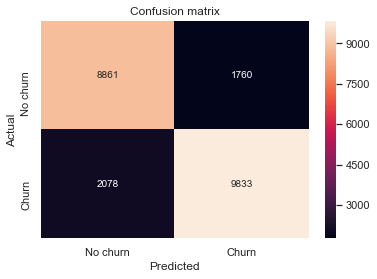

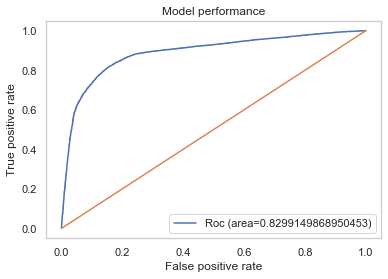

In [39]:
# Model 18 CatBoost without Feature engineering
cat = CatBoostClassifier()
churn_prediction2(cat,X1_train,X1_test,y1_train, y1_test) 

Learning rate set to 0.055938
0:	learn: 0.6572336	total: 10.3ms	remaining: 10.3s
1:	learn: 0.6252051	total: 23.7ms	remaining: 11.8s
2:	learn: 0.5995397	total: 38.9ms	remaining: 12.9s
3:	learn: 0.5750071	total: 50.4ms	remaining: 12.5s
4:	learn: 0.5537402	total: 63.4ms	remaining: 12.6s
5:	learn: 0.5370045	total: 74.9ms	remaining: 12.4s
6:	learn: 0.5208246	total: 84.7ms	remaining: 12s
7:	learn: 0.5072106	total: 93.2ms	remaining: 11.6s
8:	learn: 0.4964018	total: 101ms	remaining: 11.2s
9:	learn: 0.4856999	total: 113ms	remaining: 11.2s
10:	learn: 0.4771176	total: 124ms	remaining: 11.1s
11:	learn: 0.4697742	total: 135ms	remaining: 11.1s
12:	learn: 0.4631936	total: 147ms	remaining: 11.2s
13:	learn: 0.4567080	total: 159ms	remaining: 11.2s
14:	learn: 0.4509676	total: 171ms	remaining: 11.2s
15:	learn: 0.4459605	total: 182ms	remaining: 11.2s
16:	learn: 0.4415071	total: 195ms	remaining: 11.3s
17:	learn: 0.4381709	total: 207ms	remaining: 11.3s
18:	learn: 0.4346780	total: 217ms	remaining: 11.2s
19:	l

170:	learn: 0.4038439	total: 2s	remaining: 9.71s
171:	learn: 0.4038246	total: 2.03s	remaining: 9.75s
172:	learn: 0.4038005	total: 2.04s	remaining: 9.74s
173:	learn: 0.4037855	total: 2.06s	remaining: 9.76s
174:	learn: 0.4037716	total: 2.07s	remaining: 9.75s
175:	learn: 0.4037558	total: 2.08s	remaining: 9.73s
176:	learn: 0.4037303	total: 2.1s	remaining: 9.75s
177:	learn: 0.4036978	total: 2.11s	remaining: 9.74s
178:	learn: 0.4036620	total: 2.12s	remaining: 9.73s
179:	learn: 0.4036405	total: 2.14s	remaining: 9.75s
180:	learn: 0.4036131	total: 2.15s	remaining: 9.74s
181:	learn: 0.4035957	total: 2.16s	remaining: 9.73s
182:	learn: 0.4035829	total: 2.19s	remaining: 9.78s
183:	learn: 0.4035566	total: 2.2s	remaining: 9.78s
184:	learn: 0.4035268	total: 2.22s	remaining: 9.78s
185:	learn: 0.4035020	total: 2.23s	remaining: 9.78s
186:	learn: 0.4034808	total: 2.25s	remaining: 9.77s
187:	learn: 0.4034716	total: 2.27s	remaining: 9.8s
188:	learn: 0.4034702	total: 2.28s	remaining: 9.78s
189:	learn: 0.4034

335:	learn: 0.3999772	total: 4.02s	remaining: 7.95s
336:	learn: 0.3999534	total: 4.04s	remaining: 7.94s
337:	learn: 0.3999375	total: 4.04s	remaining: 7.92s
338:	learn: 0.3999030	total: 4.06s	remaining: 7.91s
339:	learn: 0.3998819	total: 4.07s	remaining: 7.9s
340:	learn: 0.3998540	total: 4.08s	remaining: 7.88s
341:	learn: 0.3998377	total: 4.09s	remaining: 7.87s
342:	learn: 0.3998161	total: 4.1s	remaining: 7.86s
343:	learn: 0.3997904	total: 4.11s	remaining: 7.84s
344:	learn: 0.3997779	total: 4.12s	remaining: 7.83s
345:	learn: 0.3997530	total: 4.13s	remaining: 7.82s
346:	learn: 0.3997304	total: 4.15s	remaining: 7.8s
347:	learn: 0.3997052	total: 4.16s	remaining: 7.79s
348:	learn: 0.3996789	total: 4.17s	remaining: 7.78s
349:	learn: 0.3996555	total: 4.18s	remaining: 7.76s
350:	learn: 0.3996380	total: 4.19s	remaining: 7.75s
351:	learn: 0.3996210	total: 4.2s	remaining: 7.74s
352:	learn: 0.3996051	total: 4.22s	remaining: 7.73s
353:	learn: 0.3995860	total: 4.23s	remaining: 7.71s
354:	learn: 0.39

494:	learn: 0.3968985	total: 5.84s	remaining: 5.96s
495:	learn: 0.3968864	total: 5.86s	remaining: 5.95s
496:	learn: 0.3968727	total: 5.87s	remaining: 5.94s
497:	learn: 0.3968455	total: 5.88s	remaining: 5.93s
498:	learn: 0.3968204	total: 5.89s	remaining: 5.91s
499:	learn: 0.3968081	total: 5.9s	remaining: 5.9s
500:	learn: 0.3967925	total: 5.91s	remaining: 5.89s
501:	learn: 0.3967775	total: 5.92s	remaining: 5.88s
502:	learn: 0.3967585	total: 5.93s	remaining: 5.86s
503:	learn: 0.3967366	total: 5.95s	remaining: 5.85s
504:	learn: 0.3967162	total: 5.96s	remaining: 5.84s
505:	learn: 0.3967015	total: 5.97s	remaining: 5.83s
506:	learn: 0.3966891	total: 5.98s	remaining: 5.81s
507:	learn: 0.3966768	total: 5.99s	remaining: 5.8s
508:	learn: 0.3966635	total: 6s	remaining: 5.79s
509:	learn: 0.3966479	total: 6.02s	remaining: 5.78s
510:	learn: 0.3966300	total: 6.03s	remaining: 5.77s
511:	learn: 0.3966054	total: 6.04s	remaining: 5.76s
512:	learn: 0.3965837	total: 6.05s	remaining: 5.74s
513:	learn: 0.3965

659:	learn: 0.3942389	total: 7.83s	remaining: 4.03s
660:	learn: 0.3942227	total: 7.84s	remaining: 4.02s
661:	learn: 0.3942119	total: 7.86s	remaining: 4.01s
662:	learn: 0.3941975	total: 7.87s	remaining: 4s
663:	learn: 0.3941876	total: 7.88s	remaining: 3.99s
664:	learn: 0.3941688	total: 7.89s	remaining: 3.98s
665:	learn: 0.3941410	total: 7.91s	remaining: 3.96s
666:	learn: 0.3941174	total: 7.92s	remaining: 3.95s
667:	learn: 0.3941009	total: 7.93s	remaining: 3.94s
668:	learn: 0.3940744	total: 7.94s	remaining: 3.93s
669:	learn: 0.3940615	total: 7.95s	remaining: 3.92s
670:	learn: 0.3940504	total: 7.97s	remaining: 3.91s
671:	learn: 0.3940308	total: 7.98s	remaining: 3.9s
672:	learn: 0.3940108	total: 7.99s	remaining: 3.88s
673:	learn: 0.3939985	total: 8.01s	remaining: 3.87s
674:	learn: 0.3939864	total: 8.02s	remaining: 3.86s
675:	learn: 0.3939752	total: 8.03s	remaining: 3.85s
676:	learn: 0.3939588	total: 8.05s	remaining: 3.84s
677:	learn: 0.3939508	total: 8.08s	remaining: 3.83s
678:	learn: 0.39

828:	learn: 0.3917344	total: 9.81s	remaining: 2.02s
829:	learn: 0.3917137	total: 9.83s	remaining: 2.01s
830:	learn: 0.3917043	total: 9.84s	remaining: 2s
831:	learn: 0.3916863	total: 9.85s	remaining: 1.99s
832:	learn: 0.3916708	total: 9.86s	remaining: 1.98s
833:	learn: 0.3916586	total: 9.87s	remaining: 1.96s
834:	learn: 0.3916451	total: 9.88s	remaining: 1.95s
835:	learn: 0.3916336	total: 9.89s	remaining: 1.94s
836:	learn: 0.3916207	total: 9.9s	remaining: 1.93s
837:	learn: 0.3916028	total: 9.91s	remaining: 1.92s
838:	learn: 0.3915904	total: 9.93s	remaining: 1.9s
839:	learn: 0.3915669	total: 9.94s	remaining: 1.89s
840:	learn: 0.3915558	total: 9.95s	remaining: 1.88s
841:	learn: 0.3915411	total: 9.96s	remaining: 1.87s
842:	learn: 0.3915252	total: 9.97s	remaining: 1.86s
843:	learn: 0.3915108	total: 9.98s	remaining: 1.84s
844:	learn: 0.3914950	total: 9.99s	remaining: 1.83s
845:	learn: 0.3914830	total: 10s	remaining: 1.82s
846:	learn: 0.3914754	total: 10s	remaining: 1.81s
847:	learn: 0.3914609

987:	learn: 0.3895555	total: 11.6s	remaining: 141ms
988:	learn: 0.3895404	total: 11.6s	remaining: 129ms
989:	learn: 0.3895287	total: 11.7s	remaining: 118ms
990:	learn: 0.3895120	total: 11.7s	remaining: 106ms
991:	learn: 0.3894932	total: 11.7s	remaining: 94.2ms
992:	learn: 0.3894821	total: 11.7s	remaining: 82.4ms
993:	learn: 0.3894716	total: 11.7s	remaining: 70.6ms
994:	learn: 0.3894600	total: 11.7s	remaining: 58.8ms
995:	learn: 0.3894435	total: 11.7s	remaining: 47.1ms
996:	learn: 0.3894289	total: 11.7s	remaining: 35.3ms
997:	learn: 0.3894146	total: 11.7s	remaining: 23.5ms
998:	learn: 0.3894034	total: 11.8s	remaining: 11.8ms
999:	learn: 0.3893895	total: 11.8s	remaining: 0us

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.81      0.83      0.82     10621
         1.0       0.85      0.82      0.83     11911

    accuracy                           0.83     22532
   macro avg       0.83      0.83      0.83     22532
weighted avg      

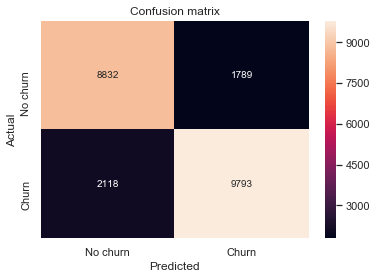

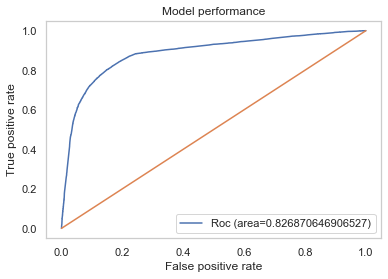

In [40]:
# Model 19 CatBoost with RFE
churn_prediction2(cat,X2_train,X2_test,y2_train,y2_test)

Learning rate set to 0.055938
0:	learn: 0.6641497	total: 12.6ms	remaining: 12.5s
1:	learn: 0.6388062	total: 24.8ms	remaining: 12.4s
2:	learn: 0.6167261	total: 37ms	remaining: 12.3s
3:	learn: 0.5960178	total: 48.4ms	remaining: 12.1s
4:	learn: 0.5764120	total: 59.2ms	remaining: 11.8s
5:	learn: 0.5600242	total: 70.1ms	remaining: 11.6s
6:	learn: 0.5451746	total: 83.3ms	remaining: 11.8s
7:	learn: 0.5316895	total: 95.9ms	remaining: 11.9s
8:	learn: 0.5214762	total: 108ms	remaining: 11.9s
9:	learn: 0.5111325	total: 119ms	remaining: 11.8s
10:	learn: 0.5017587	total: 131ms	remaining: 11.8s
11:	learn: 0.4939496	total: 143ms	remaining: 11.8s
12:	learn: 0.4873327	total: 156ms	remaining: 11.8s
13:	learn: 0.4806384	total: 170ms	remaining: 12s
14:	learn: 0.4745240	total: 184ms	remaining: 12.1s
15:	learn: 0.4689250	total: 200ms	remaining: 12.3s
16:	learn: 0.4644354	total: 214ms	remaining: 12.4s
17:	learn: 0.4606367	total: 227ms	remaining: 12.4s
18:	learn: 0.4564060	total: 239ms	remaining: 12.4s
19:	lea

166:	learn: 0.4040430	total: 2.38s	remaining: 11.9s
167:	learn: 0.4039615	total: 2.39s	remaining: 11.9s
168:	learn: 0.4038646	total: 2.41s	remaining: 11.9s
169:	learn: 0.4037807	total: 2.43s	remaining: 11.9s
170:	learn: 0.4036955	total: 2.44s	remaining: 11.9s
171:	learn: 0.4036425	total: 2.46s	remaining: 11.8s
172:	learn: 0.4035830	total: 2.47s	remaining: 11.8s
173:	learn: 0.4035334	total: 2.49s	remaining: 11.8s
174:	learn: 0.4034481	total: 2.5s	remaining: 11.8s
175:	learn: 0.4033530	total: 2.52s	remaining: 11.8s
176:	learn: 0.4032896	total: 2.54s	remaining: 11.8s
177:	learn: 0.4031986	total: 2.55s	remaining: 11.8s
178:	learn: 0.4030900	total: 2.56s	remaining: 11.8s
179:	learn: 0.4030401	total: 2.59s	remaining: 11.8s
180:	learn: 0.4029551	total: 2.6s	remaining: 11.8s
181:	learn: 0.4028918	total: 2.62s	remaining: 11.8s
182:	learn: 0.4027806	total: 2.63s	remaining: 11.8s
183:	learn: 0.4026688	total: 2.65s	remaining: 11.7s
184:	learn: 0.4026036	total: 2.66s	remaining: 11.7s
185:	learn: 0.

332:	learn: 0.3918248	total: 4.56s	remaining: 9.14s
333:	learn: 0.3917708	total: 4.58s	remaining: 9.12s
334:	learn: 0.3917033	total: 4.59s	remaining: 9.11s
335:	learn: 0.3916490	total: 4.6s	remaining: 9.09s
336:	learn: 0.3915672	total: 4.61s	remaining: 9.07s
337:	learn: 0.3914894	total: 4.62s	remaining: 9.06s
338:	learn: 0.3914001	total: 4.64s	remaining: 9.04s
339:	learn: 0.3913623	total: 4.65s	remaining: 9.02s
340:	learn: 0.3912847	total: 4.66s	remaining: 9.01s
341:	learn: 0.3912399	total: 4.67s	remaining: 8.99s
342:	learn: 0.3911650	total: 4.68s	remaining: 8.97s
343:	learn: 0.3911117	total: 4.7s	remaining: 8.96s
344:	learn: 0.3910247	total: 4.71s	remaining: 8.94s
345:	learn: 0.3909696	total: 4.72s	remaining: 8.92s
346:	learn: 0.3909021	total: 4.74s	remaining: 8.91s
347:	learn: 0.3908516	total: 4.75s	remaining: 8.9s
348:	learn: 0.3907859	total: 4.76s	remaining: 8.88s
349:	learn: 0.3907317	total: 4.77s	remaining: 8.86s
350:	learn: 0.3906583	total: 4.79s	remaining: 8.85s
351:	learn: 0.3

491:	learn: 0.3822974	total: 6.57s	remaining: 6.79s
492:	learn: 0.3821923	total: 6.59s	remaining: 6.77s
493:	learn: 0.3821182	total: 6.6s	remaining: 6.76s
494:	learn: 0.3820638	total: 6.61s	remaining: 6.74s
495:	learn: 0.3820373	total: 6.62s	remaining: 6.73s
496:	learn: 0.3819727	total: 6.64s	remaining: 6.72s
497:	learn: 0.3819012	total: 6.65s	remaining: 6.7s
498:	learn: 0.3818454	total: 6.66s	remaining: 6.69s
499:	learn: 0.3817850	total: 6.67s	remaining: 6.67s
500:	learn: 0.3817461	total: 6.68s	remaining: 6.66s
501:	learn: 0.3817051	total: 6.7s	remaining: 6.65s
502:	learn: 0.3816415	total: 6.71s	remaining: 6.63s
503:	learn: 0.3815963	total: 6.72s	remaining: 6.62s
504:	learn: 0.3815291	total: 6.74s	remaining: 6.6s
505:	learn: 0.3814816	total: 6.75s	remaining: 6.59s
506:	learn: 0.3814103	total: 6.76s	remaining: 6.58s
507:	learn: 0.3813490	total: 6.78s	remaining: 6.56s
508:	learn: 0.3812951	total: 6.79s	remaining: 6.55s
509:	learn: 0.3812434	total: 6.8s	remaining: 6.54s
510:	learn: 0.381

654:	learn: 0.3737402	total: 8.75s	remaining: 4.61s
655:	learn: 0.3736910	total: 8.76s	remaining: 4.59s
656:	learn: 0.3736557	total: 8.77s	remaining: 4.58s
657:	learn: 0.3736208	total: 8.79s	remaining: 4.57s
658:	learn: 0.3735823	total: 8.8s	remaining: 4.55s
659:	learn: 0.3735135	total: 8.81s	remaining: 4.54s
660:	learn: 0.3734717	total: 8.82s	remaining: 4.53s
661:	learn: 0.3734268	total: 8.84s	remaining: 4.51s
662:	learn: 0.3733930	total: 8.85s	remaining: 4.5s
663:	learn: 0.3733353	total: 8.86s	remaining: 4.49s
664:	learn: 0.3732936	total: 8.88s	remaining: 4.47s
665:	learn: 0.3732543	total: 8.89s	remaining: 4.46s
666:	learn: 0.3732143	total: 8.9s	remaining: 4.44s
667:	learn: 0.3731648	total: 8.91s	remaining: 4.43s
668:	learn: 0.3731255	total: 8.93s	remaining: 4.42s
669:	learn: 0.3730648	total: 8.94s	remaining: 4.4s
670:	learn: 0.3729983	total: 8.95s	remaining: 4.39s
671:	learn: 0.3729497	total: 8.97s	remaining: 4.38s
672:	learn: 0.3728952	total: 8.98s	remaining: 4.36s
673:	learn: 0.37

813:	learn: 0.3662365	total: 10.8s	remaining: 2.46s
814:	learn: 0.3661837	total: 10.8s	remaining: 2.44s
815:	learn: 0.3661521	total: 10.8s	remaining: 2.43s
816:	learn: 0.3660926	total: 10.8s	remaining: 2.42s
817:	learn: 0.3660736	total: 10.8s	remaining: 2.4s
818:	learn: 0.3660385	total: 10.8s	remaining: 2.39s
819:	learn: 0.3659933	total: 10.8s	remaining: 2.38s
820:	learn: 0.3659332	total: 10.8s	remaining: 2.36s
821:	learn: 0.3658961	total: 10.9s	remaining: 2.35s
822:	learn: 0.3658589	total: 10.9s	remaining: 2.34s
823:	learn: 0.3657979	total: 10.9s	remaining: 2.32s
824:	learn: 0.3657388	total: 10.9s	remaining: 2.31s
825:	learn: 0.3657149	total: 10.9s	remaining: 2.3s
826:	learn: 0.3656405	total: 10.9s	remaining: 2.28s
827:	learn: 0.3656154	total: 10.9s	remaining: 2.27s
828:	learn: 0.3655813	total: 10.9s	remaining: 2.26s
829:	learn: 0.3655488	total: 11s	remaining: 2.24s
830:	learn: 0.3655201	total: 11s	remaining: 2.23s
831:	learn: 0.3654752	total: 11s	remaining: 2.22s
832:	learn: 0.365432

985:	learn: 0.3589269	total: 12.9s	remaining: 184ms
986:	learn: 0.3588756	total: 12.9s	remaining: 171ms
987:	learn: 0.3588200	total: 13s	remaining: 157ms
988:	learn: 0.3587886	total: 13s	remaining: 144ms
989:	learn: 0.3587448	total: 13s	remaining: 131ms
990:	learn: 0.3587033	total: 13s	remaining: 118ms
991:	learn: 0.3586573	total: 13s	remaining: 105ms
992:	learn: 0.3586185	total: 13s	remaining: 91.8ms
993:	learn: 0.3585598	total: 13s	remaining: 78.7ms
994:	learn: 0.3585167	total: 13.1s	remaining: 65.6ms
995:	learn: 0.3584843	total: 13.1s	remaining: 52.5ms
996:	learn: 0.3584549	total: 13.1s	remaining: 39.4ms
997:	learn: 0.3583928	total: 13.1s	remaining: 26.2ms
998:	learn: 0.3583535	total: 13.1s	remaining: 13.1ms
999:	learn: 0.3583341	total: 13.1s	remaining: 0us

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.80      0.84      0.82     10621
         1.0       0.85      0.81      0.83     11911

    accuracy                         

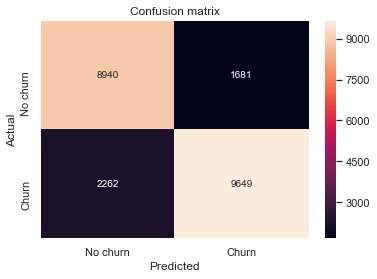

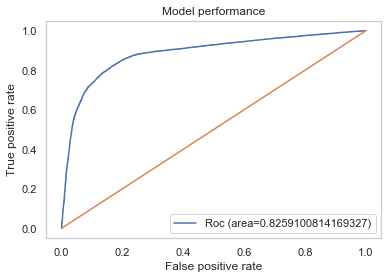

In [41]:
# Model 20 CatBoost with PCA
churn_prediction2(cat,X1_PCA,pca.transform(X1_test),y1_train,y1_test)

# Hyper-parameter tuning

In [42]:
# Tuning of KNN with RFE
model = KNeighborsClassifier()
params= {'n_neighbors': range(10,21,2), 'weights':['uniform', 'distance'], \
         'metric' :  ['manhattan', 'minkowski']}

cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
grid_search = GridSearchCV(estimator = model, param_grid=params, n_jobs=-1, scoring ='recall', cv=cv)
grid_result=grid_search.fit(X1,y)
print(f'Best {grid_result.best_score_} using {grid_result.best_params_}')

Best 0.8061222515631274 using {'metric': 'minkowski', 'n_neighbors': 20, 'weights': 'uniform'}


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.80      0.83      0.82     10621
         1.0       0.85      0.81      0.83     11911

    accuracy                           0.82     22532
   macro avg       0.82      0.82      0.82     22532
weighted avg       0.82      0.82      0.82     22532

Accuracy   Score :  0.8227409905911592
Recall Score :  0.8131978843086223
Precision Score :  0.8455696202531645
Area under curve :  0.8233205314585198 



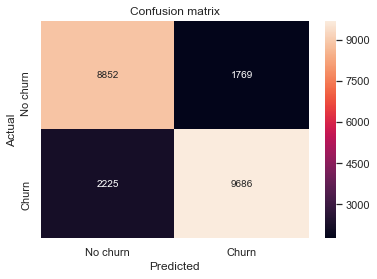

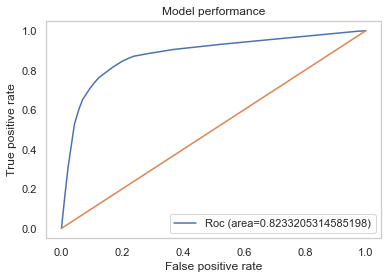

In [43]:
model1=KNeighborsClassifier(n_neighbors=20, metric = 'minkowski', weights = 'uniform')
churn_prediction2(model1,X2_train,X2_test,y2_train, y2_test)

In [44]:
# Tuning of Catboost classifier with RFE
model=CatBoostClassifier()
params = {'depth':[3,6,9],\
          'iterations':[250,500],\
          'learning_rate':[0.03,0.1]}

cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)
grid_search = GridSearchCV(estimator = model, param_grid=params, n_jobs=-1, scoring ='recall', cv=cv)
grid_result=grid_search.fit(X1,y)
print(f'Best {grid_result.best_score_} using {grid_result.best_params_}')

0:	learn: 0.6734665	total: 13.3ms	remaining: 3.32s
1:	learn: 0.6552041	total: 24.9ms	remaining: 3.09s
2:	learn: 0.6393465	total: 34.8ms	remaining: 2.86s
3:	learn: 0.6245850	total: 45.9ms	remaining: 2.82s
4:	learn: 0.6097875	total: 55.1ms	remaining: 2.7s
5:	learn: 0.5970336	total: 64.6ms	remaining: 2.63s
6:	learn: 0.5842140	total: 73.7ms	remaining: 2.56s
7:	learn: 0.5732003	total: 83.5ms	remaining: 2.52s
8:	learn: 0.5621007	total: 93.6ms	remaining: 2.5s
9:	learn: 0.5525911	total: 104ms	remaining: 2.49s
10:	learn: 0.5437441	total: 114ms	remaining: 2.47s
11:	learn: 0.5347559	total: 124ms	remaining: 2.46s
12:	learn: 0.5264318	total: 134ms	remaining: 2.45s
13:	learn: 0.5193395	total: 145ms	remaining: 2.44s
14:	learn: 0.5121256	total: 156ms	remaining: 2.45s
15:	learn: 0.5059800	total: 167ms	remaining: 2.44s
16:	learn: 0.4997397	total: 176ms	remaining: 2.41s
17:	learn: 0.4950019	total: 186ms	remaining: 2.4s
18:	learn: 0.4895395	total: 198ms	remaining: 2.4s
19:	learn: 0.4844603	total: 210ms	re

161:	learn: 0.4088287	total: 1.65s	remaining: 898ms
162:	learn: 0.4088151	total: 1.66s	remaining: 888ms
163:	learn: 0.4087903	total: 1.67s	remaining: 877ms
164:	learn: 0.4087645	total: 1.68s	remaining: 866ms
165:	learn: 0.4087527	total: 1.69s	remaining: 855ms
166:	learn: 0.4087401	total: 1.7s	remaining: 845ms
167:	learn: 0.4087287	total: 1.71s	remaining: 834ms
168:	learn: 0.4087108	total: 1.72s	remaining: 824ms
169:	learn: 0.4086939	total: 1.73s	remaining: 813ms
170:	learn: 0.4086816	total: 1.74s	remaining: 802ms
171:	learn: 0.4086749	total: 1.75s	remaining: 792ms
172:	learn: 0.4086577	total: 1.76s	remaining: 783ms
173:	learn: 0.4086435	total: 1.77s	remaining: 774ms
174:	learn: 0.4086286	total: 1.78s	remaining: 764ms
175:	learn: 0.4086117	total: 1.8s	remaining: 755ms
176:	learn: 0.4085949	total: 1.81s	remaining: 745ms
177:	learn: 0.4085808	total: 1.83s	remaining: 739ms
178:	learn: 0.4085687	total: 1.84s	remaining: 728ms
179:	learn: 0.4085500	total: 1.85s	remaining: 718ms
180:	learn: 0.

0:	learn: 0.6735113	total: 8.51ms	remaining: 2.12s
1:	learn: 0.6552896	total: 17.7ms	remaining: 2.19s
2:	learn: 0.6383925	total: 29.1ms	remaining: 2.39s
3:	learn: 0.6237047	total: 38.9ms	remaining: 2.39s
4:	learn: 0.6100356	total: 46.9ms	remaining: 2.3s
5:	learn: 0.5963531	total: 55.4ms	remaining: 2.25s
6:	learn: 0.5845455	total: 63.4ms	remaining: 2.2s
7:	learn: 0.5735754	total: 71.5ms	remaining: 2.16s
8:	learn: 0.5633556	total: 79.1ms	remaining: 2.12s
9:	learn: 0.5530016	total: 87.6ms	remaining: 2.1s
10:	learn: 0.5441794	total: 95.8ms	remaining: 2.08s
11:	learn: 0.5358976	total: 104ms	remaining: 2.07s
12:	learn: 0.5275009	total: 112ms	remaining: 2.04s
13:	learn: 0.5204179	total: 119ms	remaining: 2.01s
14:	learn: 0.5131405	total: 127ms	remaining: 1.99s
15:	learn: 0.5064009	total: 136ms	remaining: 1.98s
16:	learn: 0.5013365	total: 143ms	remaining: 1.96s
17:	learn: 0.4959916	total: 151ms	remaining: 1.95s
18:	learn: 0.4915537	total: 159ms	remaining: 1.93s
19:	learn: 0.4866088	total: 170ms

172:	learn: 0.4087790	total: 1.44s	remaining: 642ms
173:	learn: 0.4087622	total: 1.45s	remaining: 634ms
174:	learn: 0.4087432	total: 1.46s	remaining: 626ms
175:	learn: 0.4087325	total: 1.47s	remaining: 618ms
176:	learn: 0.4087220	total: 1.48s	remaining: 609ms
177:	learn: 0.4087117	total: 1.48s	remaining: 601ms
178:	learn: 0.4087035	total: 1.49s	remaining: 592ms
179:	learn: 0.4086918	total: 1.5s	remaining: 583ms
180:	learn: 0.4086810	total: 1.51s	remaining: 575ms
181:	learn: 0.4086652	total: 1.51s	remaining: 566ms
182:	learn: 0.4086542	total: 1.52s	remaining: 558ms
183:	learn: 0.4086435	total: 1.53s	remaining: 549ms
184:	learn: 0.4086363	total: 1.54s	remaining: 540ms
185:	learn: 0.4086227	total: 1.55s	remaining: 532ms
186:	learn: 0.4085973	total: 1.55s	remaining: 524ms
187:	learn: 0.4085809	total: 1.56s	remaining: 515ms
188:	learn: 0.4085698	total: 1.57s	remaining: 507ms
189:	learn: 0.4085561	total: 1.58s	remaining: 499ms
190:	learn: 0.4085463	total: 1.59s	remaining: 490ms
191:	learn: 0

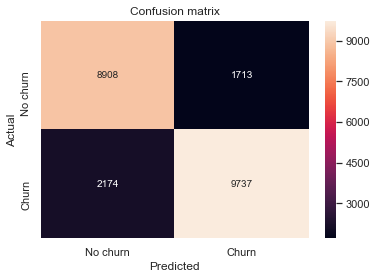

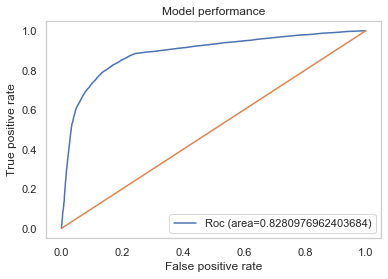

In [45]:
model2= CatBoostClassifier(depth= 3, iterations= 250, learning_rate= 0.03)
churn_prediction2(model2,X2_train,X2_test,y2_train, y2_test)

# Ensemble

In [46]:
# V1 : Logistic Regression + Catboost
estimators = [('neigh', model1), ('cat', model2)]
ensemble = VotingClassifier(estimators, voting='hard')

In [49]:
model3= ensemble.fit(X2_train, y2_train)
y_pred3 = model3.predict(X2_test)

0:	learn: 0.6735113	total: 8.35ms	remaining: 2.08s
1:	learn: 0.6552896	total: 16.4ms	remaining: 2.03s
2:	learn: 0.6383925	total: 24.2ms	remaining: 1.99s
3:	learn: 0.6237047	total: 32.1ms	remaining: 1.98s
4:	learn: 0.6100356	total: 40.4ms	remaining: 1.98s
5:	learn: 0.5963531	total: 48.6ms	remaining: 1.98s
6:	learn: 0.5845455	total: 56.6ms	remaining: 1.96s
7:	learn: 0.5735754	total: 64.1ms	remaining: 1.94s
8:	learn: 0.5633556	total: 71.9ms	remaining: 1.93s
9:	learn: 0.5530016	total: 80.2ms	remaining: 1.93s
10:	learn: 0.5441794	total: 88.4ms	remaining: 1.92s
11:	learn: 0.5358976	total: 96.1ms	remaining: 1.91s
12:	learn: 0.5275009	total: 104ms	remaining: 1.9s
13:	learn: 0.5204179	total: 111ms	remaining: 1.87s
14:	learn: 0.5131405	total: 119ms	remaining: 1.87s
15:	learn: 0.5064009	total: 127ms	remaining: 1.85s
16:	learn: 0.5013365	total: 135ms	remaining: 1.85s
17:	learn: 0.4959916	total: 143ms	remaining: 1.84s
18:	learn: 0.4915537	total: 153ms	remaining: 1.86s
19:	learn: 0.4866088	total: 16

176:	learn: 0.4087220	total: 1.45s	remaining: 597ms
177:	learn: 0.4087117	total: 1.46s	remaining: 589ms
178:	learn: 0.4087035	total: 1.46s	remaining: 581ms
179:	learn: 0.4086918	total: 1.47s	remaining: 573ms
180:	learn: 0.4086810	total: 1.48s	remaining: 564ms
181:	learn: 0.4086652	total: 1.49s	remaining: 556ms
182:	learn: 0.4086542	total: 1.49s	remaining: 547ms
183:	learn: 0.4086435	total: 1.5s	remaining: 539ms
184:	learn: 0.4086363	total: 1.51s	remaining: 530ms
185:	learn: 0.4086227	total: 1.52s	remaining: 523ms
186:	learn: 0.4085973	total: 1.53s	remaining: 514ms
187:	learn: 0.4085809	total: 1.53s	remaining: 506ms
188:	learn: 0.4085698	total: 1.54s	remaining: 497ms
189:	learn: 0.4085561	total: 1.55s	remaining: 490ms
190:	learn: 0.4085463	total: 1.56s	remaining: 481ms
191:	learn: 0.4085262	total: 1.56s	remaining: 473ms
192:	learn: 0.4085161	total: 1.57s	remaining: 465ms
193:	learn: 0.4085030	total: 1.58s	remaining: 457ms
194:	learn: 0.4084986	total: 1.59s	remaining: 449ms
195:	learn: 0


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.79      0.86      0.82     10621
         1.0       0.86      0.79      0.83     11911

    accuracy                           0.82     22532
   macro avg       0.82      0.83      0.82     22532
weighted avg       0.83      0.82      0.82     22532

Accuracy   Score :  0.8232291851588851
Recall   Score :  0.790781630425657
Precision Score :  0.8633363886342805


Text(0.5, 1, 'Confusion matrix')

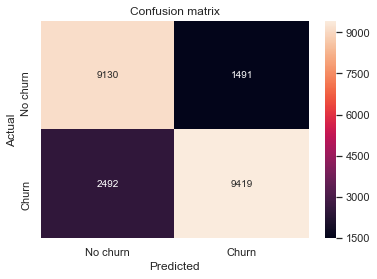

In [52]:

print ("\n Classification report : \n",classification_report(y2_test,y_pred3))
print ("Accuracy   Score : ",accuracy_score(y2_test,y_pred3))
print ("Recall   Score : ",recall_score(y2_test,y_pred3))
print("Precision Score : ",precision_score(y2_test,y_pred3))
#confusion matrix
conf_matrix = confusion_matrix(y2_test,y_pred3)
#roc_auc_score
model_roc_auc = roc_auc_score(y2_test,y_pred3) 

    
#plot confusion matrix
plt.figure()
matrix =sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
matrix.set_xticklabels(['No churn', 'Churn'])
matrix.set_yticklabels(['No churn', 'Churn'])
matrix.set_title('Confusion matrix')




In [53]:
# Save the model into a pickle
def pickle_file(output_file_name, object_to_pickle):
    with open(output_file_name, 'wb') as out_file:
        pickle.dump(object_to_pickle, out_file)

pickle_file('Men_churn_model_2', model2)